In [ ]:
!pip install ray

In [1]:
import colorsys
import ray
import matplotlib.pyplot as plt
import numpy as np
from ray.util import ActorPool

In [2]:

# Animation parameters
FPS = 30
NUM_SEC = 30
ZOOM_RATE = 0.99
MAX_ITER = 1000

# Image parameters
XY_PROP = 3/2
Y_DIM = 512
X_DIM = int(XY_PROP * Y_DIM)
IMG_DIM = (X_DIM, Y_DIM)

# Complex plane parameters
CENTER = (-0.7845, -0.1272)
Y_LENGTH = 2
X_LENGTH = XY_PROP * Y_LENGTH

def get_windows(scale=1):
    x_window = [CENTER[0] - scale * X_LENGTH / 2, 
                CENTER[0] + scale * X_LENGTH / 2]
    y_window = [CENTER[1] - scale * Y_LENGTH / 2, 
                CENTER[1] + scale * Y_LENGTH / 2]
    return x_window, y_window

def rgb_conv(i):
    color = 255 * np.array(colorsys.hsv_to_rgb(i / 255.0, 1.0, 0.5))
    return tuple(color.astype(int))

def mandelbrot(x, y):
    c, z = complex(x, y), 0
    for i in range(1000):
        if abs(z) > 2:
            return rgb_conv(i)
        z = z * z + c
    return (0, 0, 0)

def get_frame(frame_num):
    x_window, y_window = get_windows(scale=ZOOM_RATE ** frame_num)
    print(x_window, y_window)

    pixels = np.zeros((Y_DIM, X_DIM, 3), int)

    x = np.linspace(x_window[0], x_window[1], IMG_DIM[0]).reshape(1, IMG_DIM[0])
    y = np.linspace(y_window[0], y_window[1], IMG_DIM[1]).reshape(IMG_DIM[1], 1)

    c = x + 1j * y
    z = np.zeros(c.shape, dtype=np.complex128)

    iterations = np.zeros(z.shape, dtype=np.uint8)
    active = np.full(c.shape, True, dtype=bool)

    for i in range(MAX_ITER):
        z[active] = z[active]**2 + c[active]

        diverged = np.greater(np.abs(z), 2.236, out=np.full(c.shape, False), where=active)
        iterations[diverged] = i
        active[np.abs(z) > 2.236] = False
    iterations[active] = MAX_ITER + 1
    return frame_num, iterations

In [ ]:
from ray.util.multiprocessing import Pool

pool = Pool(4)
results = pool.map(get_frame, [1, 2, 3, 4])

In [ ]:
pool = Pool(4)
results = pool.map(get_frame, [1, 2, 3, 4])

In [4]:
@ray.remote
class FractalActor:
    MAX_ITER = 1000
    
    def get_frame(self, frame_num):
        x_window, y_window = get_windows(scale=ZOOM_RATE ** frame_num)
        print(x_window, y_window)
        
        pixels = np.zeros((Y_DIM, X_DIM, 3), int)

        x = np.linspace(x_window[0], x_window[1], IMG_DIM[0]).reshape(1, IMG_DIM[0])
        y = np.linspace(y_window[0], y_window[1], IMG_DIM[1]).reshape(IMG_DIM[1], 1)

        c = x + 1j * y
        z = np.zeros(c.shape, dtype=np.complex128)
        
        iterations = np.zeros(z.shape, dtype=np.uint8)
        active = np.full(c.shape, True, dtype=bool)

        for i in range(self.MAX_ITER):
            z[active] = z[active]**2 + c[active]
            
            diverged = np.greater(np.abs(z), 2.236, out=np.full(c.shape, False), where=active)
            iterations[diverged] = i
            active[np.abs(z) > 2.236] = False
        iterations[active] = self.MAX_ITER + 1
        return frame_num, iterations

In [ ]:
# Get just one frame to make sure everything looks good
a = FractalActor.remote()
frame_num, frame = ray.get(a.get_frame.remote(FPS * NUM_SEC + 100))
plt.imshow(frame)

In [ ]:
%%capture

# Create a pool of actors, one per CPU core
num_processes = int(ray.cluster_resources()['CPU'])
actors = [FractalActor.remote() for _ in range(num_processes)]
pool = ActorPool(actors)

In [ ]:
num_frames = FPS * NUM_SEC
frames = np.zeros((num_frames, Y_DIM, X_DIM), int)

# Evaluate all frames
for frame_num, frame in pool.map_unordered(
    lambda a, v: a.get_frame.remote(v), list(range(num_frames))):
    frames[frame_num] = frame

In [ ]:
np.save(f'frames_{FPS}_{NUM_SEC}.npy', frames)

In [ ]:
plt.imshow(frames[0])

In [ ]:
#frames = np.load(f'frames_{FPS}_{NUM_SEC}.npy')

from PIL import Image

im = plt.imshow(frames[0], interpolation='none')

for i, frame in enumerate(frames):
    c_frame = 255 * im.cmap(im.norm(frame))
    c_frame = np.delete(c_frame, -1, axis=2).astype(np.uint8)
    image = Image.fromarray(c_frame)
    image.save(f'frames/frame_{i:05}.png')

In [11]:
import os
os.mkdirs('test')

AttributeError: module 'os' has no attribute 'mkdirs'

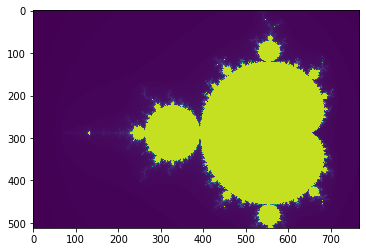

In [10]:
from PIL import Image

im = plt.imshow(results[0][1], interpolation='none')

